When tasked with distinguishing between sclerotic and non-sclerotic glomeruli from kidney biopsy samples, the first step is to thoroughly understand the dataset’s characteristics and structure. These biopsy samples from human kidneys have been precisely segmented from whole slide images using advanced machine learning techniques and categorized into different subfolders based on whether the glomeruli exhibit global sclerosis. Each image presents a detailed patch of a single glomerulus, providing an ideal dataset for training a robust image classification model.

In this dataset, sclerotic glomeruli are characterized by darker tones and blurred tissue textures, with fewer cells and almost invisible capillaries. In contrast, non-sclerotic glomeruli show abundant cells, clear capillaries, and well-defined tissue structures. These clear visual and structural differences are the key features that the model needs to learn and distinguish accurately.

ResNet152 was initially chosen as the classification model based on several considerations. First, ResNet152 is a deep convolutional neural network that addresses the gradient vanishing problem commonly encountered in training deep models through residual learning (also known as skip connections). This design allows the network to retain early learned information while benefiting from deeper layers. This is crucial for our task, as identifying subtle texture and structural differences in glomeruli requires deep feature extraction.

Moreover, ResNet152 has been pre-trained on large-scale image recognition tasks like ImageNet, meaning it already possesses a strong foundation for recognizing general image features. Through transfer learning, we can fine-tune this pre-trained model to better classify the sclerotic states of glomeruli. This approach not only saves significant training time and computational resources but also enhances the model’s performance and generalization ability on this specific small dataset.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/train_aug_resize.zip -d /content/

流式输出内容被截断，只能显示最后 5000 行内容。
  inflating: /content/train_aug_resize/S-1908-000892_PAS_1of2_647582a4435c92704a441257_3.png  
  inflating: /content/train_aug_resize/S-1908-000892_PAS_1of2_647582a4435c92704a441259.png  
  inflating: /content/train_aug_resize/S-1908-000892_PAS_1of2_647582a4435c92704a441259_1.png  
  inflating: /content/train_aug_resize/S-1908-000892_PAS_1of2_647582a4435c92704a441259_2.png  
  inflating: /content/train_aug_resize/S-1908-000892_PAS_1of2_647582a4435c92704a441259_3.png  
  inflating: /content/train_aug_resize/S-1908-000892_PAS_1of2_647582a4435c92704a44125a.png  
  inflating: /content/train_aug_resize/S-1908-000892_PAS_1of2_647582a4435c92704a44125a_1.png  
  inflating: /content/train_aug_resize/S-1908-000892_PAS_1of2_647582a4435c92704a44125a_2.png  
  inflating: /content/train_aug_resize/S-1908-000892_PAS_1of2_647582a4435c92704a44125a_3.png  
  inflating: /content/train_aug_resize/S-1908-000892_PAS_1of2_647582a4435c92704a44125b.png  
  inflating: /content/train_a

In [ ]:
!unzip /content/drive/MyDrive/val_resize.zip -d /content/

Archive:  /content/drive/MyDrive/val_resize.zip
   creating: /content/val_resize/
  inflating: /content/val_resize/18-142_PAS_1of6_647e17ac435c92704a564fe8.png  
  inflating: /content/val_resize/18-142_PAS_2of6_64551bbb435c92704a39934f.png  
  inflating: /content/val_resize/18-142_PAS_2of6_64551bbb435c92704a399351.png  
  inflating: /content/val_resize/18-142_PAS_2of6_64551bbb435c92704a39935a.png  
  inflating: /content/val_resize/18-142_PAS_2of6_64551bbb435c92704a399362.png  
  inflating: /content/val_resize/18-142_PAS_2of6_64551bbb435c92704a39937e.png  
  inflating: /content/val_resize/18-142_PAS_2of6_64551bbb435c92704a399384.png  
  inflating: /content/val_resize/18-142_PAS_2of6_64551bbb435c92704a399388.png  
  inflating: /content/val_resize/18-142_PAS_2of6_64551bbb435c92704a39938d.png  
  inflating: /content/val_resize/18-142_PAS_2of6_64551bbb435c92704a39938e.png  
  inflating: /content/val_resize/18-142_PAS_3of6_64551bc4435c92704a39b4a6.png  
  inflating: /content/val_resize/18-14

In [ ]:
!unzip /content/drive/MyDrive/test_resize.zip -d /content/

Archive:  /content/drive/MyDrive/test_resize.zip
   creating: /content/test_resize/
  inflating: /content/test_resize/18-142_PAS_1of6_647e17ac435c92704a564fee.png  
  inflating: /content/test_resize/18-142_PAS_1of6_647e17ac435c92704a564ffb.png  
  inflating: /content/test_resize/18-142_PAS_1of6_647e17ac435c92704a565001.png  
  inflating: /content/test_resize/18-142_PAS_2of6_64551bbb435c92704a399336.png  
  inflating: /content/test_resize/18-142_PAS_2of6_64551bbb435c92704a399337.png  
  inflating: /content/test_resize/18-142_PAS_2of6_64551bbb435c92704a39933a.png  
  inflating: /content/test_resize/18-142_PAS_2of6_64551bbb435c92704a399363.png  
  inflating: /content/test_resize/18-142_PAS_2of6_64551bbb435c92704a39936b.png  
  inflating: /content/test_resize/18-142_PAS_2of6_64551bbb435c92704a39936d.png  
  inflating: /content/test_resize/18-142_PAS_2of6_64551bbb435c92704a39936f.png  
  inflating: /content/test_resize/18-142_PAS_2of6_64551bbb435c92704a399375.png  
  inflating: /content/tes

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os
import pandas as pd
import torch
import torch.nn as nn
import torchvision.models as models
from torch.optim import Adam
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix
from torchvision.models import resnet152, ResNet152_Weights


When loading the dataset, it is crucial to ensure that each image corresponds correctly to its label. Since each image in the training set undergoes augmentation, resulting in three new augmented images for each original image, I need to ensure that the newly generated augmented images are also matched with their corresponding ground truth labels before proceeding with training.

In [ ]:
class ImageDataset(Dataset):
    def __init__(self, img_folder, csv_file, transform=None):
        self.img_folder = img_folder
        self.df = pd.read_csv(csv_file)
        self.transform = transform

        # Create a dictionary to store the ground truth for each image, using get_original_name to handle suffixes
        self.image_labels = {self.get_original_name(row['name']): row['ground truth'] for _, row in self.df.iterrows()}

    def __len__(self):
        return len(os.listdir(self.img_folder))

    def __getitem__(self, idx):
        img_name = os.listdir(self.img_folder)[idx]
        img_path = os.path.join(self.img_folder, img_name)

        # Get the original name without augmentation suffix
        original_name = self.get_original_name(img_name)

        # Load image
        image = Image.open(img_path)

        if self.transform:
            image = self.transform(image)

        # Get the label from the original name
        if original_name in self.image_labels:
            label = self.image_labels[original_name]
        else:
            # Notify which image is not found in CSV
            raise ValueError(f"Label for image {original_name} not found in CSV file.")

        return image, label

    def get_original_name(self, filename):
        # Check if the filename ends with _1, _2, or _3, and remove it if present
        if filename.endswith('_1.png') or filename.endswith('_2.png') or filename.endswith('_3.png'):
            original_name = filename.rsplit('_', 1)[0] + '.png'
        else:
            original_name = filename
        return original_name


In [ ]:

img_folder = 'train_aug_resize'
csv_file = '/content/public.csv'


dataset = ImageDataset(img_folder=img_folder, csv_file=csv_file)


import random
for i in range(30):
    idx = random.randint(0, len(dataset) - 1)
    try:
        img_name = os.listdir(img_folder)[idx]
        image, label = dataset[idx]
        print(f"Image Name: {img_name}, Label: {label}")
    except ValueError as e:
        print(e)

Image Name: 18-142_PAS_1of6_647e17ac435c92704a564fe1.png, Label: 0
Image Name: S-2102-006223_PAS_1of2_645527f3435c92704a3ed4cb_1.png, Label: 1
Image Name: 18-162_PAS_5of6_64551c0e435c92704a3a9c69_1.png, Label: 1
Image Name: S-2006-003979_PAS_1of2_645432f4435c92704a38c1ed.png, Label: 0
Image Name: S-2101-000841_PAS_2of2_645527ae435c92704a3e3c2a.png, Label: 0
Image Name: S-2010-012995_PAS_2of2_64552787435c92704a3dea9b.png, Label: 0
Image Name: S-2006-004999_PAS_2of2_64543340435c92704a393614_2.png, Label: 1
Image Name: S-2001-000137_PAS_1of2_64542e69435c92704a33d9d6.png, Label: 0
Image Name: S-1910-000089_PAS_2of2_64551d48435c92704a3d0343_3.png, Label: 1
Image Name: S-1908-010066_PAS_1of2_647582be435c92704a4438c1.png, Label: 0
Image Name: S-2101-000842_PAS_1of2_645527b4435c92704a3e4763.png, Label: 1
Image Name: S-2002-007649_PAS_1of2_64542f17435c92704a351648.png, Label: 0
Image Name: S-2010-013042_PAS_2of2_64552790435c92704a3dfb81_2.png, Label: 1
Image Name: S-2102-006457_PAS_2of2_645527f

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor()
])


train_dataset = ImageDataset(img_folder='train_aug_resize', csv_file='/content/public.csv', transform=transform)


train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)


val_dataset = ImageDataset(img_folder='val_resize', csv_file='/content/public.csv', transform=transform)


val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

test_dataset = ImageDataset(img_folder='test_resize', csv_file='/content/public.csv', transform=transform)


test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)



I set up early stopping to allow the model to automatically find the optimal number of training epochs, preventing overtraining.

In [ ]:

class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

# **ResNet152 Model 1**

In [ ]:


model = resnet152(weights=ResNet152_Weights.IMAGENET1K_V1)


num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.001, weight_decay=1e-05)



To prevent overfitting, L2 regularization (weight decay) was introduced. Multiple parameters were tested to allow the model to find the optimal value.

Early stopping triggered at weight decay 1e-05.
Early stopping triggered at weight decay 5e-05.
Early stopping triggered at weight decay 0.0001.
Early stopping triggered at weight decay 0.0005.
Early stopping triggered at weight decay 0.001.


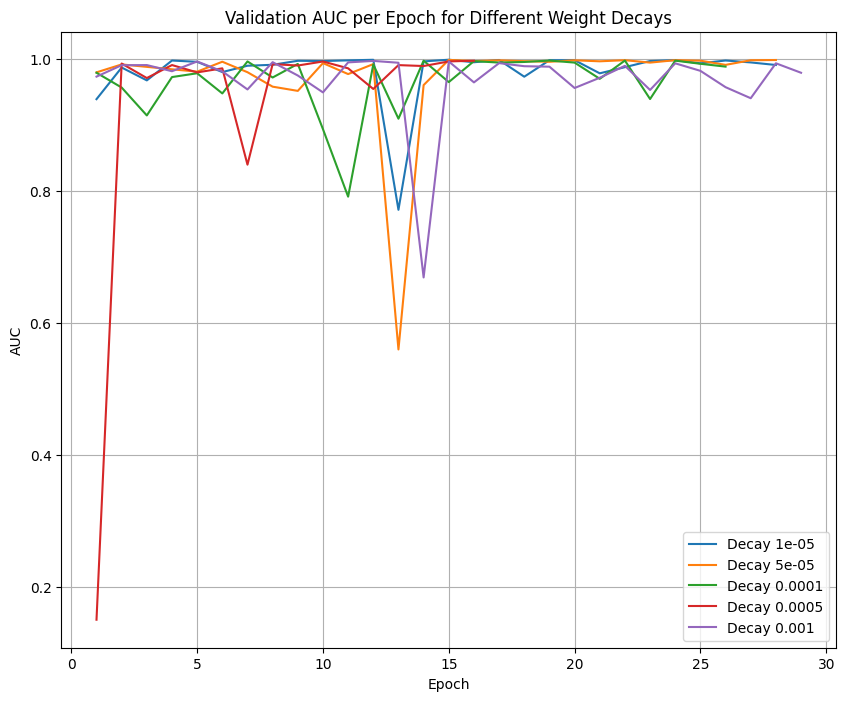

Best AUC: 0.9993635027073546 at Weight Decay: 1e-05


In [ ]:

weight_decays = [1e-5, 5e-5, 1e-4, 5e-4, 1e-3]
best_auc = 0
best_decay = 0
all_decays_aucs = []

for decay in weight_decays:

    model = resnet152(weights=ResNet152_Weights.IMAGENET1K_V1)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 2)
    model = model.to(device)


    optimizer = Adam(model.parameters(), lr=0.001, weight_decay=decay)
    early_stopping = EarlyStopping(patience=15, min_delta=0.001)

    val_aucs = []

    for epoch in range(num_epochs):
        model.train()
        for images, labels in train_loader:
          images = images.to(device)
          labels = labels.to(device)
          optimizer.zero_grad()
          outputs = model(images)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()

        model.eval()
        all_labels = []
        all_preds = []
        with torch.no_grad():
            for val_images, val_labels in val_loader:
              val_images = val_images.to(device)
              val_labels = val_labels.to(device)
              val_outputs = model(val_images)
              preds = torch.softmax(val_outputs, dim=1)[:, 1].cpu().numpy()
              all_preds.extend(preds)
              all_labels.extend(val_labels.cpu().numpy())

        val_auc = roc_auc_score(all_labels, all_preds)
        val_aucs.append(val_auc)

        early_stopping(val_auc)
        if early_stopping.early_stop:
          print(f"Early stopping triggered at weight decay {decay}.")
          break

        if val_auc > best_auc:
          best_auc = val_auc
          best_decay = decay
          best_model_wts = model.state_dict()

    all_decays_aucs.append(val_aucs)


plt.figure(figsize=(10, 8))
for i, decays_aucs in enumerate(all_decays_aucs):
  plt.plot(range(1, len(decays_aucs)+1), decays_aucs, label=f"Decay {weight_decays[i]}")
plt.title("Validation AUC per Epoch for Different Weight Decays")
plt.xlabel("Epoch")
plt.ylabel("AUC")
plt.legend()
plt.grid()
plt.show()


model.load_state_dict(best_model_wts)
print(f'Best AUC: {best_auc} at Weight Decay: {best_decay}')


In [ ]:
test_running_loss = 0.0
all_labels = []
all_probs = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)
        test_running_loss += loss.item() * images.size(0)

        probs = torch.sigmoid(outputs).cpu().numpy()
        all_probs.extend(probs)
        all_labels.extend(labels.cpu().numpy())

test_loss = test_running_loss / len(test_loader.dataset)


all_probs_np = np.array(all_probs)

test_auc = roc_auc_score(all_labels, all_probs_np[:, 1])

predicted_labels = np.argmax(all_probs_np, axis=1)
precision, recall, f1_score, _ = precision_recall_fscore_support(all_labels, predicted_labels, average='binary')


print(f'Test Loss: {test_loss:.4f}')
print(f'Test AUC: {test_auc:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1_score:.4f}')


Test Loss: 0.3396
Test AUC: 0.9908
Precision: 0.9700
Recall: 0.6101
F1 Score: 0.7490


In [ ]:
cm = confusion_matrix(all_labels, predicted_labels)
print(cm)

[[703   3]
 [ 62  97]]


Although the training set AUC is very high, the test set AUC remains close to 1 (0.9908), indicating that the model still exhibits strong discriminatory power on the test data without significant overfitting. Overfitting typically shows up as a high training AUC with a much lower test AUC (e.g., dropping to below 0.80).

The higher Precision but lower Recall suggests that the model is being cautious in predicting the positive class, potentially missing some positive samples. This issue may not necessarily be due to overfitting but could be related to class imbalance or the model's inherent bias.

Next, I'll try using Weighted Cross Entropy to address the low recall caused by class imbalance. The weight for class 0 is calculated as (3292+2948)/3292 = 1.19, and for class 1, it's (3292+2948)/2948 = 1.21, which is roughly 1:1.02. To make the model focus more on class 1, I will start by setting the class weight to 1:2 and see how it impacts the performance.

# **ResNet152 Model 2**
To avoid continuing with the results from the previous ResNet152 Model 4, the session needs to be restarted, and the execution should begin again from the data loading step.

In [ ]:

model = resnet152(weights=ResNet152_Weights.IMAGENET1K_V1)


num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


class_weights = torch.tensor([1.0, 2.0]).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)


optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)


early_stopping = EarlyStopping(patience=15, min_delta=0.001)

Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth
100%|██████████| 230M/230M [00:01<00:00, 182MB/s]


Epoch [1/300], Train Loss: 0.1778, Val Loss: 0.3577, Val AUC: 0.9880
Epoch [2/300], Train Loss: 0.0877, Val Loss: 0.1134, Val AUC: 0.9925
Epoch [3/300], Train Loss: 0.0659, Val Loss: 0.0712, Val AUC: 0.9963
Epoch [4/300], Train Loss: 0.0508, Val Loss: 0.2948, Val AUC: 0.9938
Epoch [5/300], Train Loss: 0.0586, Val Loss: 0.3072, Val AUC: 0.9874
Epoch [6/300], Train Loss: 0.0478, Val Loss: 0.6704, Val AUC: 0.9869
Epoch [7/300], Train Loss: 0.0342, Val Loss: 0.1190, Val AUC: 0.9938
Epoch [8/300], Train Loss: 0.0236, Val Loss: 0.2526, Val AUC: 0.9937
Epoch [9/300], Train Loss: 0.0353, Val Loss: 0.0373, Val AUC: 0.9991
Epoch [10/300], Train Loss: 0.0158, Val Loss: 1.6552, Val AUC: 0.9832
Epoch [11/300], Train Loss: 0.0298, Val Loss: 0.1562, Val AUC: 0.9923
Epoch [12/300], Train Loss: 0.0143, Val Loss: 0.1218, Val AUC: 0.9963
Epoch [13/300], Train Loss: 0.0094, Val Loss: 0.1059, Val AUC: 0.9985
Epoch [14/300], Train Loss: 0.0242, Val Loss: 0.0958, Val AUC: 0.9961
Epoch [15/300], Train Loss: 0

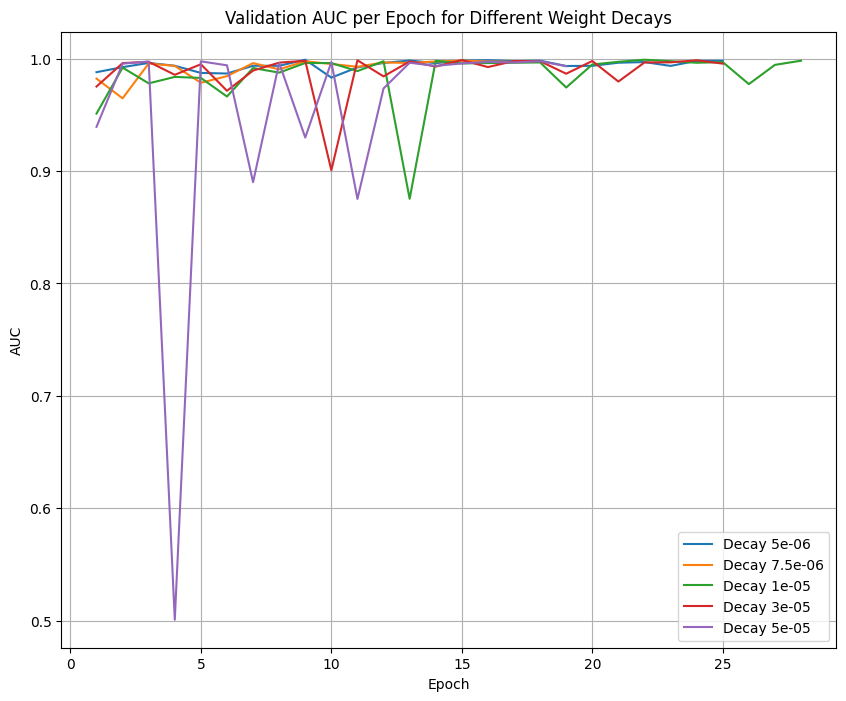

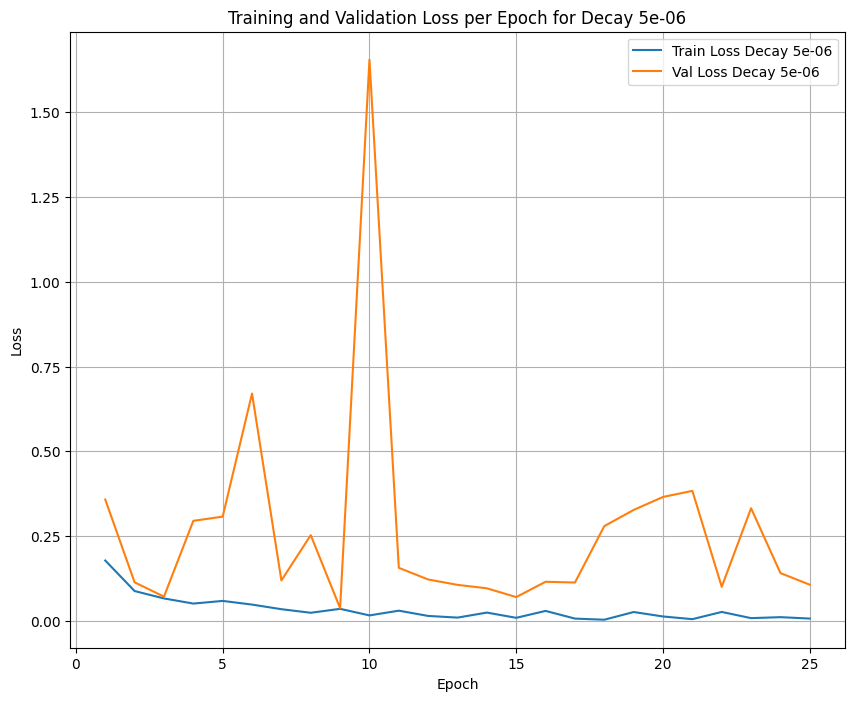

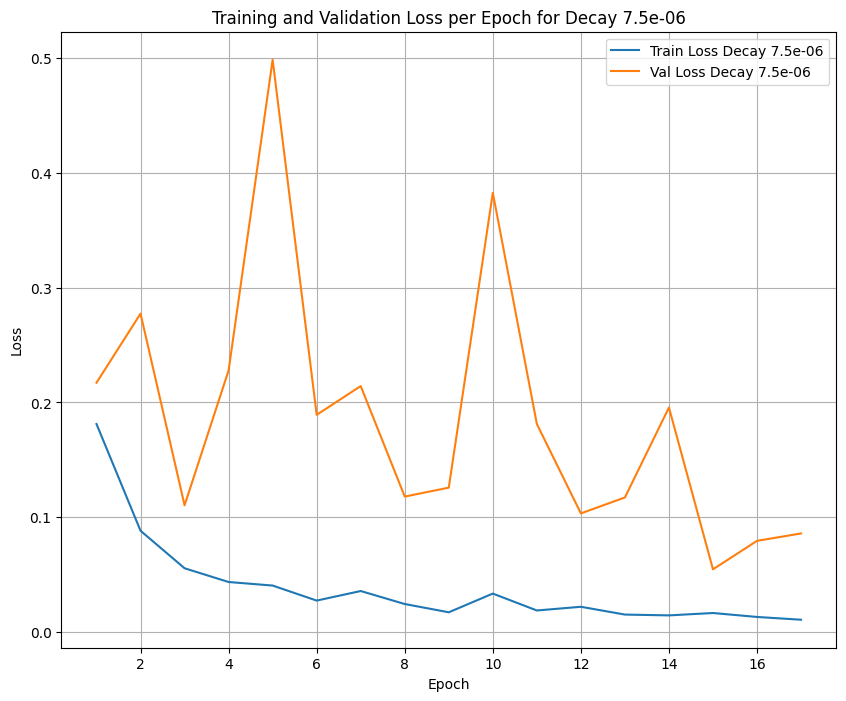

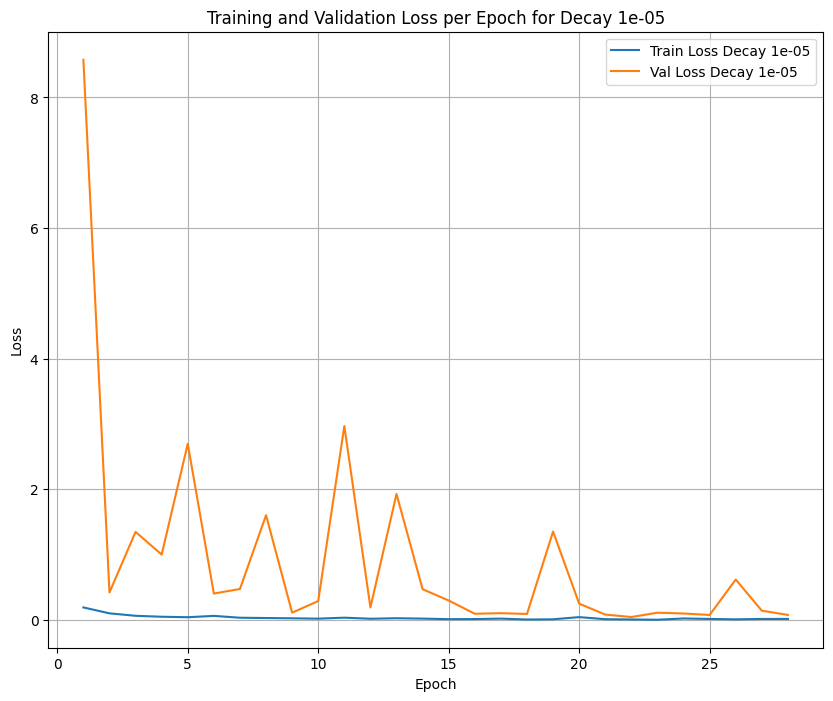

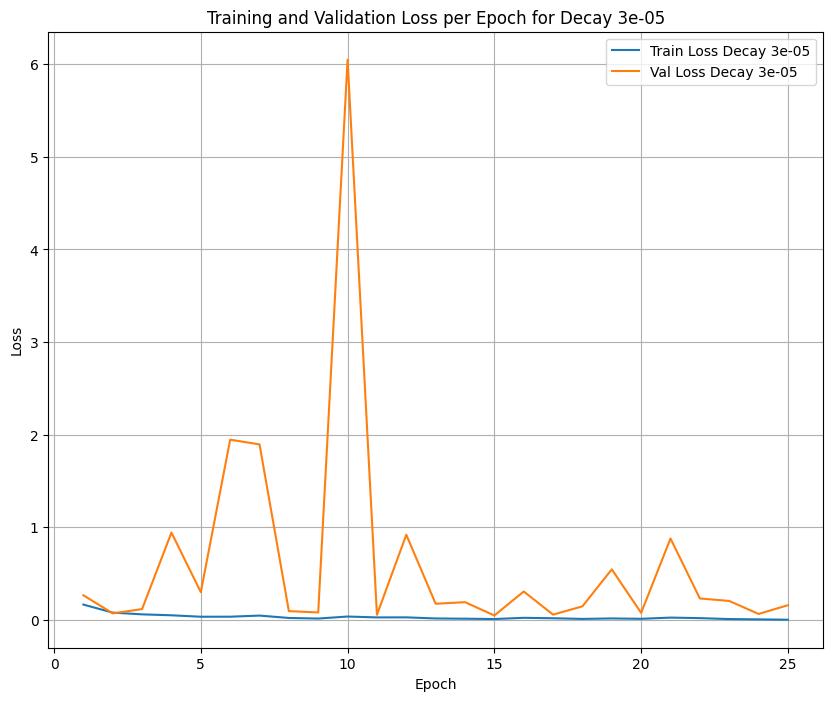

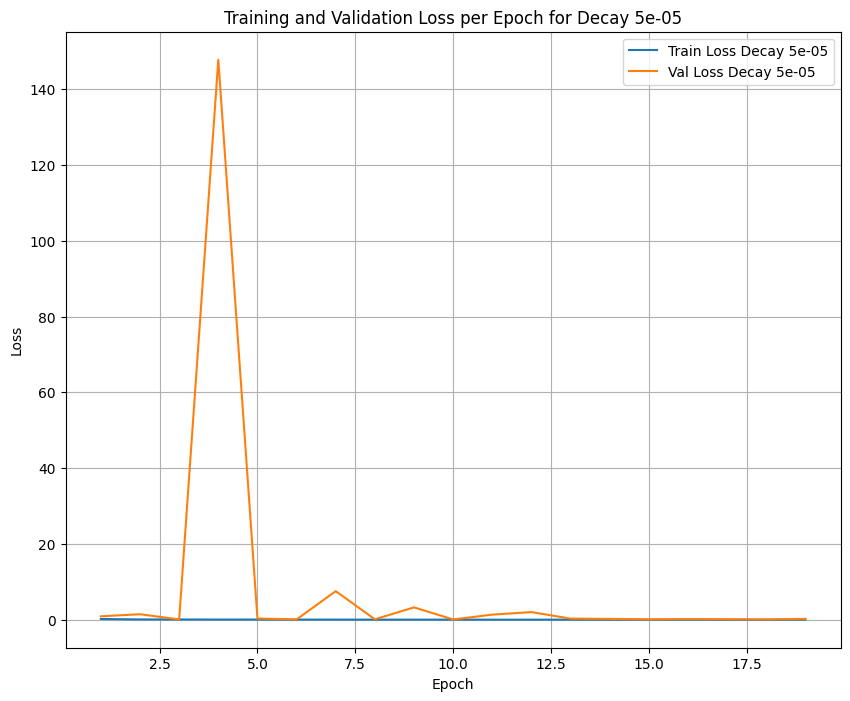

流式输出内容被截断，只能显示最后 5000 行内容。
         0.0441, -0.0115,  0.0342,  0.0314,  0.0444,  0.0539,  0.0431,  0.0312,
         0.0300, -0.0350,  0.0341,  0.0201,  0.0517, -0.0038, -0.0077,  0.0737,
        -0.0095,  0.0064,  0.0423, -0.0174,  0.0484, -0.0117, -0.0025,  0.0412,
        -0.0108, -0.0157, -0.0243, -0.0086, -0.0153,  0.0217, -0.0126, -0.0315,
         0.0175,  0.0460, -0.0072, -0.0065, -0.0068, -0.0172, -0.0148,  0.0422,
         0.0330,  0.0396, -0.0205,  0.0224, -0.0119,  0.0067, -0.0365,  0.0050,
         0.0196,  0.0024, -0.0177,  0.0383,  0.0362,  0.0379,  0.0591,  0.0531,
        -0.0094,  0.0529,  0.0059, -0.0003,  0.0303, -0.0272, -0.0174, -0.0131,
        -0.0455,  0.0622,  0.0215,  0.0406,  0.0260,  0.0367, -0.0324,  0.0394,
        -0.0178, -0.0173, -0.0151,  0.0297, -0.0042, -0.0133,  0.0274, -0.0276,
        -0.0267,  0.0128,  0.0221,  0.0650, -0.0076,  0.0354,  0.0405,  0.0416,
         0.0282, -0.0180,  0.0273,  0.0386,  0.0341,  0.0450,  0.0187, -0.0075,
         0.05

In [ ]:
weight_decays = [5e-6, 7.5e-6, 1e-5, 3e-5, 5e-5]
num_epochs = 300
best_auc = 0
best_decay = 0
all_decays_aucs = []
all_decays_losses = []

for decay in weight_decays:

    model = resnet152(weights=ResNet152_Weights.IMAGENET1K_V1)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 2)
    model = model.to(device)


    optimizer = Adam(model.parameters(), lr=0.001, weight_decay=decay)
    early_stopping = EarlyStopping(patience=15, min_delta=0.001)


    val_aucs = []
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
          images = images.to(device)
          labels = labels.to(device)
          optimizer.zero_grad()
          outputs = model(images)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()
          running_loss += loss.item() * images.size(0)


        epoch_train_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_train_loss)

        model.eval()
        all_labels = []
        all_preds = []
        val_running_loss = 0.0
        with torch.no_grad():
            for val_images, val_labels in val_loader:
              val_images = val_images.to(device)
              val_labels = val_labels.to(device)
              val_outputs = model(val_images)
              val_loss = criterion(val_outputs, val_labels)
              val_running_loss += val_loss.item() * val_images.size(0)
              preds = torch.softmax(val_outputs, dim=1)[:, 1].cpu().numpy()
              all_preds.extend(preds)
              all_labels.extend(val_labels.cpu().numpy())

        epoch_val_loss = val_running_loss / len(val_loader.dataset)
        val_losses.append(epoch_val_loss)
        val_auc = roc_auc_score(all_labels, all_preds)
        val_aucs.append(val_auc)

        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}, Val AUC: {val_auc:.4f}")

        early_stopping(val_auc)
        if early_stopping.early_stop:
          print(f"Early stopping triggered at weight decay {decay}.")
          break

        if val_auc > best_auc:
          best_auc = val_auc
          best_decay = decay
          best_model_wts = model.state_dict()

    all_decays_aucs.append(val_aucs)
    all_decays_losses.append((train_losses, val_losses))



plt.figure(figsize=(10, 8))
for i, decays_aucs in enumerate(all_decays_aucs):
  plt.plot(range(1, len(decays_aucs)+1), decays_aucs, label=f"Decay {weight_decays[i]}")
plt.title("Validation AUC per Epoch for Different Weight Decays")
plt.xlabel("Epoch")
plt.ylabel("AUC")
plt.legend()
plt.grid()
plt.show()


for i, (train_losses, val_losses) in enumerate(all_decays_losses):
    plt.figure(figsize=(10, 8))
    plt.plot(range(1, len(train_losses)+1), train_losses, label=f"Train Loss Decay {weight_decays[i]}")
    plt.plot(range(1, len(val_losses)+1), val_losses, label=f"Val Loss Decay {weight_decays[i]}")
    plt.title(f"Training and Validation Loss per Epoch for Decay {weight_decays[i]}")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid()
    plt.show()


model.load_state_dict(best_model_wts)
print(f'Best AUC: {best_auc} at Weight Decay: {best_decay}')


for param_tensor in model.state_dict():
    print(f"Layer: {param_tensor} | Size: {model.state_dict()[param_tensor].size()} | Values: {model.state_dict()[param_tensor]}")


In [ ]:
print(f'Best AUC: {best_auc} at Weight Decay: {best_decay}')

Best AUC: 0.9991483486929393 at Weight Decay: 5e-06


In [ ]:

model.load_state_dict(best_model_wts)


test_running_loss = 0.0
all_labels = []
all_probs = []


model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)
        test_running_loss += loss.item() * images.size(0)


        probs = torch.sigmoid(outputs).cpu().numpy()
        all_probs.extend(probs)
        all_labels.extend(labels.cpu().numpy())


test_loss = test_running_loss / len(test_loader.dataset)


all_probs_np = np.array(all_probs)
test_auc = roc_auc_score(all_labels, all_probs_np[:, 1])


predicted_labels = np.argmax(all_probs_np, axis=1)
precision, recall, f1_score, _ = precision_recall_fscore_support(all_labels, predicted_labels, average='binary')
cm = confusion_matrix(all_labels, predicted_labels)

print(f'Test Loss: {test_loss:.4f}')
print(f'Test AUC: {test_auc:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1_score:.4f}')
print(f'Confusion Matrix: {cm}')

Test Loss: 0.1222
Test AUC: 0.9979
Precision: 0.8503
Recall: 1.0000
F1 Score: 0.9191
Confusion Matrix: [[678  28]
 [  0 159]]


When the recall in the test set reaches 1.0, it means the model successfully identified all positive samples without any false negatives. However, with a precision of only 0.85, it indicates that while there were no missed positives, the model incorrectly classified some negative samples as positive (false positives), resulting in misclassification.

In other words, the model ensures that no positive cases are missed, but at the cost of increasing the false positive rate. If the application scenario is highly sensitive to missed positives, this may be acceptable; however, if reducing false positives and improving overall decision quality is a priority, adjustments to the model or parameters, such as modifying the classification threshold, should be considered to balance recall and precision.

Now, I will use weight_decay=5e-6, the best parameter from the previous run, and test class_weights = torch.tensor([1.0, 1.5]).to(device) and class_weights = torch.tensor([1.0, 1.8]).to(device) to see if precision can be improved.







# **ResNet152 Model 3**
To avoid continuing with the results from the previous ResNet152 Model 4, the session needs to be restarted, and the execution should begin again from the data loading step.

In [ ]:

model = resnet152(weights=ResNet152_Weights.IMAGENET1K_V1)


num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


class_weights = torch.tensor([1.0, 1.5]).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)


optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-6)


early_stopping = EarlyStopping(patience=15, min_delta=0.001)

Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth
100%|██████████| 230M/230M [00:01<00:00, 213MB/s]


Epoch [1/300], Train Loss: 0.1861, Val Loss: 0.2884, Val AUC: 0.9418
Epoch [2/300], Train Loss: 0.0856, Val Loss: 0.8082, Val AUC: 0.9947
Epoch [3/300], Train Loss: 0.0581, Val Loss: 0.3187, Val AUC: 0.9973
Epoch [4/300], Train Loss: 0.0547, Val Loss: 2.3636, Val AUC: 0.9738
Epoch [5/300], Train Loss: 0.0497, Val Loss: 1.1838, Val AUC: 0.9862
Epoch [6/300], Train Loss: 0.0317, Val Loss: 0.1187, Val AUC: 0.9951
Epoch [7/300], Train Loss: 0.0242, Val Loss: 0.1781, Val AUC: 0.9958
Epoch [8/300], Train Loss: 0.0247, Val Loss: 0.1044, Val AUC: 0.9964
Epoch [9/300], Train Loss: 0.0183, Val Loss: 4.0260, Val AUC: 0.9587
Epoch [10/300], Train Loss: 0.0344, Val Loss: 0.8781, Val AUC: 0.9905
Epoch [11/300], Train Loss: 0.0258, Val Loss: 0.3344, Val AUC: 0.9947
Epoch [12/300], Train Loss: 0.0097, Val Loss: 0.2421, Val AUC: 0.9955
Epoch [13/300], Train Loss: 0.0075, Val Loss: 0.0805, Val AUC: 0.9973
Epoch [14/300], Train Loss: 0.0181, Val Loss: 0.1149, Val AUC: 0.9992
Epoch [15/300], Train Loss: 0

ValueError: x and y must have same first dimension, but have shapes (300,) and (36,)

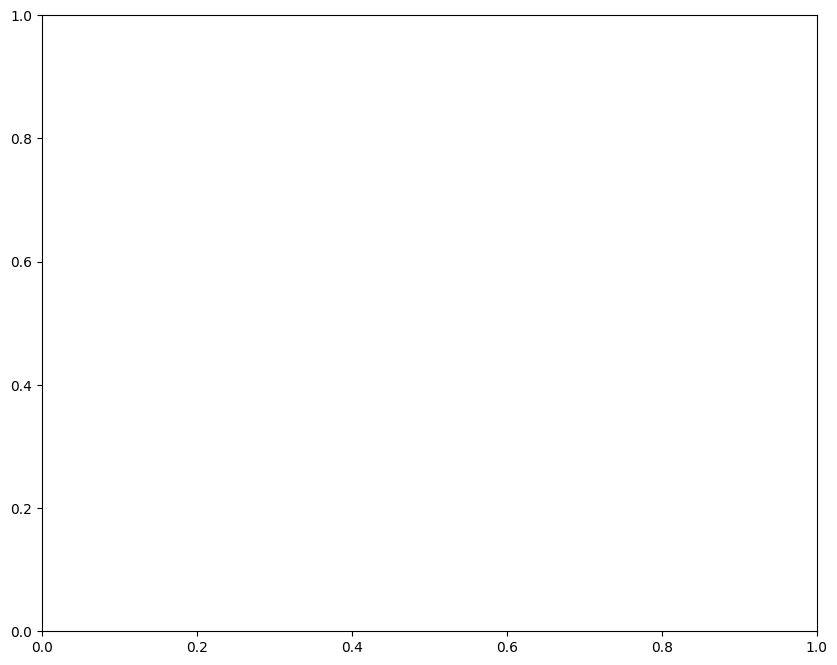

In [ ]:
num_epochs = 300
train_losses = []
val_losses = []
val_aucs = []

for epoch in range(num_epochs):
  model.train()
  running_loss = 0.0
  for images, labels in train_loader:
    images = images.to(device)
    labels = labels.to(device)
    optimizer.zero_grad()
    outputs = model(images)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    running_loss += loss.item() * images.size(0)


  epoch_train_loss = running_loss / len(train_loader.dataset)
  train_losses.append(epoch_train_loss)

  model.eval()
  all_labels = []
  all_preds = []
  val_running_loss = 0.0
  with torch.no_grad():
      for val_images, val_labels in val_loader:
        val_images = val_images.to(device)
        val_labels = val_labels.to(device)
        val_outputs = model(val_images)
        val_loss = criterion(val_outputs, val_labels)
        val_running_loss += val_loss.item() * val_images.size(0)
        preds = torch.softmax(val_outputs, dim=1)[:, 1].cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(val_labels.cpu().numpy())

  epoch_val_loss = val_running_loss / len(val_loader.dataset)
  val_losses.append(epoch_val_loss)
  val_auc = roc_auc_score(all_labels, all_preds)
  val_aucs.append(val_auc)
  print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}, Val AUC: {val_auc:.4f}")

  early_stopping(val_auc)
  if early_stopping.early_stop:
    print("Early stopping triggered.")
    break


plt.figure(figsize=(10, 8))
plt.plot(range(1, num_epochs+1), train_losses, label="Train Loss")
plt.plot(range(1, num_epochs+1), val_losses, label="Val Loss")
plt.title("Training and Validation Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()


plt.figure(figsize=(10, 8))
plt.plot(range(1, num_epochs+1), val_aucs, label="Validation AUC")
plt.title("Validation AUC per Epoch")
plt.xlabel("Epoch")
plt.ylabel("AUC")
plt.legend()
plt.grid()
plt.show()

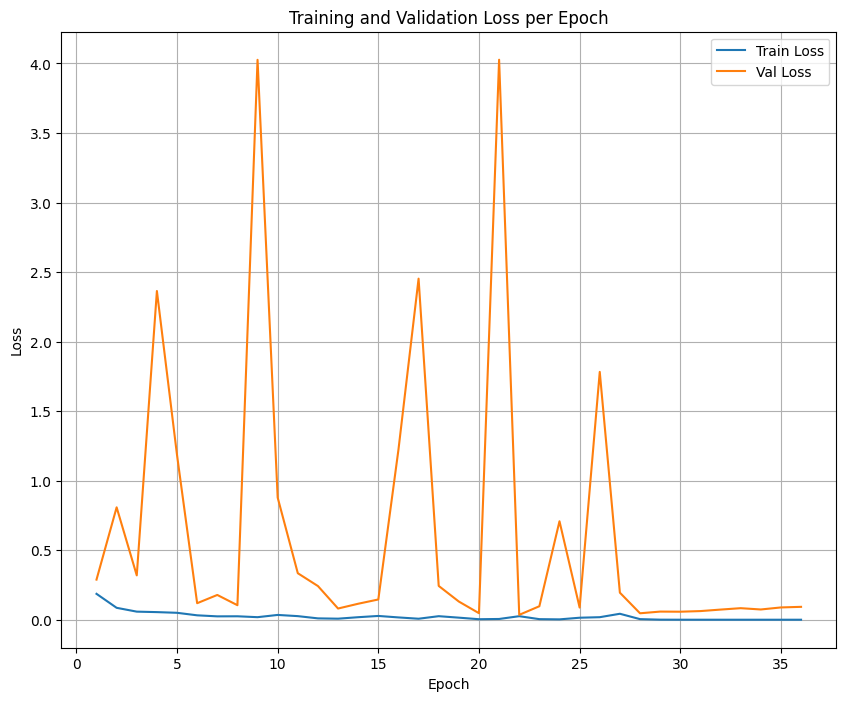

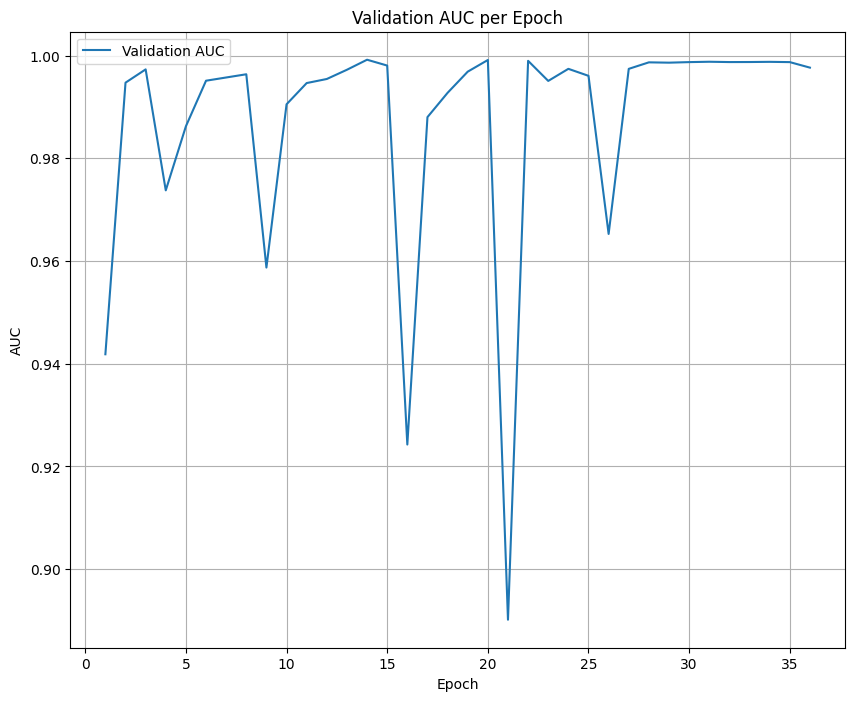

In [ ]:

plt.figure(figsize=(10, 8))
plt.plot(range(1, len(train_losses) + 1), train_losses, label="Train Loss")
plt.plot(range(1, len(val_losses) + 1), val_losses, label="Val Loss")
plt.title("Training and Validation Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()


plt.figure(figsize=(10, 8))
plt.plot(range(1, len(val_aucs) + 1), val_aucs, label="Validation AUC")
plt.title("Validation AUC per Epoch")
plt.xlabel("Epoch")
plt.ylabel("AUC")
plt.legend()
plt.grid()
plt.show()


In [ ]:

test_running_loss = 0.0
all_labels = []
all_probs = []


model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)
        test_running_loss += loss.item() * images.size(0)


        probs = torch.sigmoid(outputs).cpu().numpy()
        all_probs.extend(probs)
        all_labels.extend(labels.cpu().numpy())


test_loss = test_running_loss / len(test_loader.dataset)


all_probs_np = np.array(all_probs)
test_auc = roc_auc_score(all_labels, all_probs_np[:, 1])


predicted_labels = np.argmax(all_probs_np, axis=1)
precision, recall, f1_score, _ = precision_recall_fscore_support(all_labels, predicted_labels, average='binary')
cm = confusion_matrix(all_labels, predicted_labels)


print(f'Test Loss: {test_loss:.4f}')
print(f'Test AUC: {test_auc:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1_score:.4f}')
print(f'Confusion Matrix: {cm}')

Test Loss: 0.1264
Test AUC: 0.9978
Precision: 0.9394
Recall: 0.9748
F1 Score: 0.9568
Confusion Matrix: [[696  10]
 [  4 155]]



1.   Model2 Results:



*   Test Loss: 0.1222
*   Test AUC: 0.9979
*   Precision: 0.8503
*   Recall: 1.0000
*   F1 Score: 0.9191
*   Confusion Matrix:
            [[678, 28],
            [0, 159]]

2.   Adjusted Class Weights Results:
*   Test Loss: 0.1264
*   Test AUC: 0.9978
*   Precision: 0.9394
*   Recall: 0.9748
*   F1 Score: 0.9568
*   Confusion Matrix:
            [[696, 10],
            [ 4, 155]]

The original model achieved a lower test loss (0.1222 vs. 0.1264) and perfect recall (1.0000), but at the cost of a lower precision (0.8503). In contrast, the adjusted class weights model improved precision significantly (0.9394), reducing false positives, though with a slight drop in recall (0.9748). This results in a higher F1 score (0.9568 vs. 0.9191), indicating a better balance between precision and recall. The adjusted model, with fewer false positives (10 vs. 28), offers a more reliable solution for class imbalance, even if it sacrifices some recall. Overall, the precision-recall trade-off is more favorable with the adjusted weights.

Next, I will try modifying the class weights to ([1.0, 1.8]) to see if this can further improve the issue of class imbalance.

# **ResNet152 Model 4**
To avoid continuing with the results from the previous ResNet152 Model 4, the session needs to be restarted, and the execution should begin again from the data loading step.

In [ ]:

model = resnet152(weights=ResNet152_Weights.IMAGENET1K_V1)


num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


class_weights = torch.tensor([1.0, 1.8]).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)


optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-6)


early_stopping = EarlyStopping(patience=15, min_delta=0.001)

Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth
100%|██████████| 230M/230M [00:01<00:00, 224MB/s]


In [ ]:
num_epochs = 300
train_losses = []
val_losses = []
val_aucs = []

for epoch in range(num_epochs):
  model.train()
  running_loss = 0.0
  for images, labels in train_loader:
    images = images.to(device)
    labels = labels.to(device)
    optimizer.zero_grad()
    outputs = model(images)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    running_loss += loss.item() * images.size(0)


  epoch_train_loss = running_loss / len(train_loader.dataset)
  train_losses.append(epoch_train_loss)

  model.eval()
  all_labels = []
  all_preds = []
  val_running_loss = 0.0
  with torch.no_grad():
      for val_images, val_labels in val_loader:
        val_images = val_images.to(device)
        val_labels = val_labels.to(device)
        val_outputs = model(val_images)
        val_loss = criterion(val_outputs, val_labels)
        val_running_loss += val_loss.item() * val_images.size(0)
        preds = torch.softmax(val_outputs, dim=1)[:, 1].cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(val_labels.cpu().numpy())

  epoch_val_loss = val_running_loss / len(val_loader.dataset)
  val_losses.append(epoch_val_loss)
  val_auc = roc_auc_score(all_labels, all_preds)
  val_aucs.append(val_auc)
  print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}, Val AUC: {val_auc:.4f}")

  early_stopping(val_auc)
  if early_stopping.early_stop:
    print("Early stopping triggered.")
    break

Epoch [1/300], Train Loss: 0.1833, Val Loss: 0.3994, Val AUC: 0.9719
Epoch [2/300], Train Loss: 0.0820, Val Loss: 0.1424, Val AUC: 0.9952
Epoch [3/300], Train Loss: 0.0691, Val Loss: 0.1395, Val AUC: 0.9966
Epoch [4/300], Train Loss: 0.0486, Val Loss: 0.0659, Val AUC: 0.9986
Epoch [5/300], Train Loss: 0.0361, Val Loss: 0.1226, Val AUC: 0.9899
Epoch [6/300], Train Loss: 0.0349, Val Loss: 1.4053, Val AUC: 0.9250
Epoch [7/300], Train Loss: 0.0391, Val Loss: 0.0641, Val AUC: 0.9983
Epoch [8/300], Train Loss: 0.0222, Val Loss: 0.0555, Val AUC: 0.9977
Epoch [9/300], Train Loss: 0.0260, Val Loss: 0.5398, Val AUC: 0.9945
Epoch [10/300], Train Loss: 0.0175, Val Loss: 0.0953, Val AUC: 0.9962
Epoch [11/300], Train Loss: 0.0242, Val Loss: 0.0508, Val AUC: 0.9989
Epoch [12/300], Train Loss: 0.0117, Val Loss: 1.0165, Val AUC: 0.9934
Epoch [13/300], Train Loss: 0.0342, Val Loss: 849.5877, Val AUC: 0.5028
Epoch [14/300], Train Loss: 0.0636, Val Loss: 0.2050, Val AUC: 0.9743
Epoch [15/300], Train Loss:

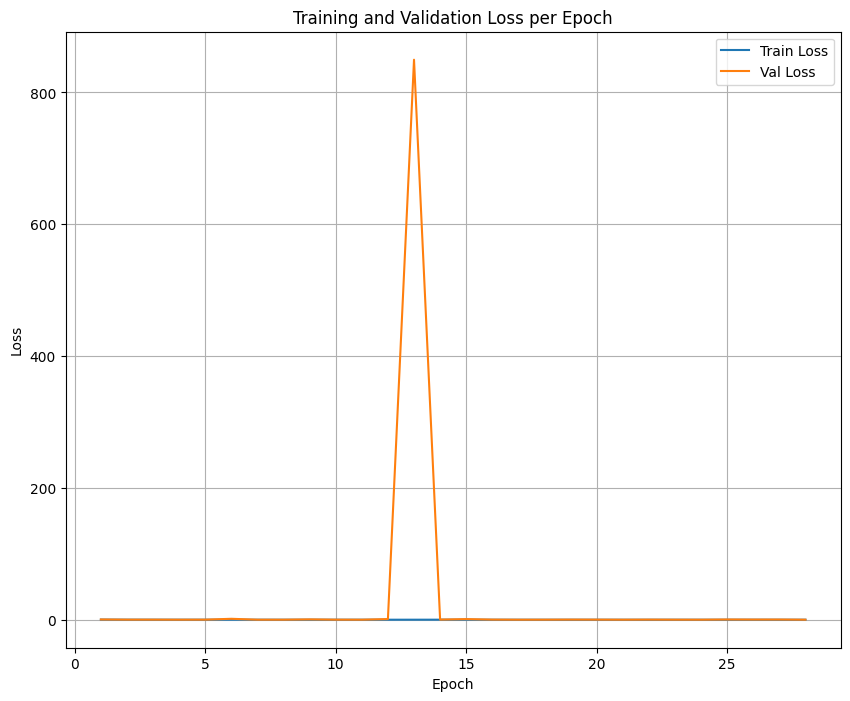

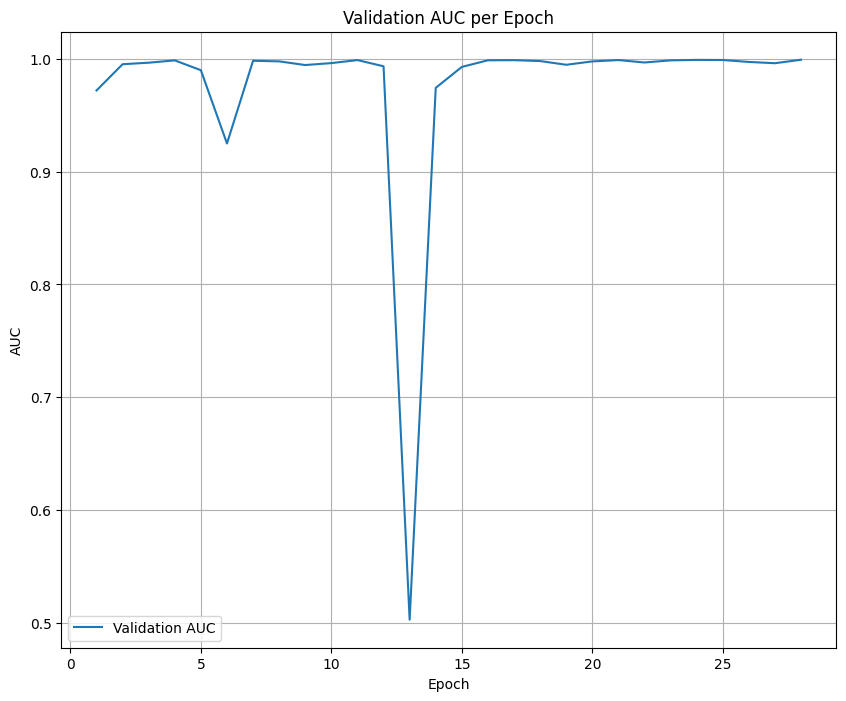

In [ ]:

plt.figure(figsize=(10, 8))
plt.plot(range(1, len(train_losses) + 1), train_losses, label="Train Loss")
plt.plot(range(1, len(val_losses) + 1), val_losses, label="Val Loss")
plt.title("Training and Validation Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()


plt.figure(figsize=(10, 8))
plt.plot(range(1, len(val_aucs) + 1), val_aucs, label="Validation AUC")
plt.title("Validation AUC per Epoch")
plt.xlabel("Epoch")
plt.ylabel("AUC")
plt.legend()
plt.grid()
plt.show()

In [ ]:

test_running_loss = 0.0
all_labels = []
all_probs = []


model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)
        test_running_loss += loss.item() * images.size(0)


        probs = torch.sigmoid(outputs).cpu().numpy()
        all_probs.extend(probs)
        all_labels.extend(labels.cpu().numpy())


test_loss = test_running_loss / len(test_loader.dataset)


all_probs_np = np.array(all_probs)
test_auc = roc_auc_score(all_labels, all_probs_np[:, 1])


predicted_labels = np.argmax(all_probs_np, axis=1)
precision, recall, f1_score, _ = precision_recall_fscore_support(all_labels, predicted_labels, average='binary')
cm = confusion_matrix(all_labels, predicted_labels)


print(f'Test Loss: {test_loss:.4f}')
print(f'Test AUC: {test_auc:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1_score:.4f}')
print(f'Confusion Matrix: {cm}')

Test Loss: 0.0847
Test AUC: 0.9979
Precision: 0.9451
Recall: 0.9748
F1 Score: 0.9598
Confusion Matrix: [[697   9]
 [  4 155]]


The F1 score increased from 0.9568 to 0.9598, indicating that a class weight of 1.8 is more suitable than 1.5. However, the validation loss spiked to 800+, suggesting that the model is not stable. Next, I'll try selecting a value between 1.8 and 1.5, such as 1.7, to see if it can better address the class imbalance issue and stabilize the model.

# **ResNet152 Model 5**
To avoid continuing with the results from the previous ResNet152 Model 4, the session needs to be restarted, and the execution should begin again from the data loading step.

In [ ]:

model = resnet152(weights=ResNet152_Weights.IMAGENET1K_V1)


num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


class_weights = torch.tensor([1.0, 1.7]).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)


optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-6)


early_stopping = EarlyStopping(patience=15, min_delta=0.001)

Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth
100%|██████████| 230M/230M [00:01<00:00, 193MB/s]


In [ ]:
num_epochs = 300
train_losses = []
val_losses = []
val_aucs = []

for epoch in range(num_epochs):
  model.train()
  running_loss = 0.0
  for images, labels in train_loader:
    images = images.to(device)
    labels = labels.to(device)
    optimizer.zero_grad()
    outputs = model(images)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    running_loss += loss.item() * images.size(0)  # Accumulate batch loss

  # Calculate and store the training loss for this epoch
  epoch_train_loss = running_loss / len(train_loader.dataset)
  train_losses.append(epoch_train_loss)

  model.eval()
  all_labels = []
  all_preds = []
  val_running_loss = 0.0
  with torch.no_grad():
      for val_images, val_labels in val_loader:
        val_images = val_images.to(device)
        val_labels = val_labels.to(device)
        val_outputs = model(val_images)
        val_loss = criterion(val_outputs, val_labels)
        val_running_loss += val_loss.item() * val_images.size(0)
        preds = torch.softmax(val_outputs, dim=1)[:, 1].cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(val_labels.cpu().numpy())

  epoch_val_loss = val_running_loss / len(val_loader.dataset)
  val_losses.append(epoch_val_loss)
  val_auc = roc_auc_score(all_labels, all_preds)
  val_aucs.append(val_auc)
  print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}, Val AUC: {val_auc:.4f}")

  early_stopping(val_auc)
  if early_stopping.early_stop:
    print("Early stopping triggered.")
    break

Epoch [1/300], Train Loss: 0.1807, Val Loss: 0.1377, Val AUC: 0.9859
Epoch [2/300], Train Loss: 0.0863, Val Loss: 0.1027, Val AUC: 0.9969
Epoch [3/300], Train Loss: 0.0696, Val Loss: 3.2115, Val AUC: 0.9722
Epoch [4/300], Train Loss: 0.0537, Val Loss: 0.3321, Val AUC: 0.9937
Epoch [5/300], Train Loss: 0.0489, Val Loss: 0.1774, Val AUC: 0.9853
Epoch [6/300], Train Loss: 0.0396, Val Loss: 0.6410, Val AUC: 0.9960
Epoch [7/300], Train Loss: 0.0302, Val Loss: 0.3598, Val AUC: 0.9842
Epoch [8/300], Train Loss: 0.0240, Val Loss: 0.1636, Val AUC: 0.9952
Epoch [9/300], Train Loss: 0.0186, Val Loss: 0.1005, Val AUC: 0.9966
Epoch [10/300], Train Loss: 0.0223, Val Loss: 0.1241, Val AUC: 0.9972
Epoch [11/300], Train Loss: 0.0266, Val Loss: 0.0683, Val AUC: 0.9973
Epoch [12/300], Train Loss: 0.0157, Val Loss: 5.4441, Val AUC: 0.9301
Epoch [13/300], Train Loss: 0.0178, Val Loss: 0.0782, Val AUC: 0.9976
Epoch [14/300], Train Loss: 0.0100, Val Loss: 0.1014, Val AUC: 0.9979
Epoch [15/300], Train Loss: 0

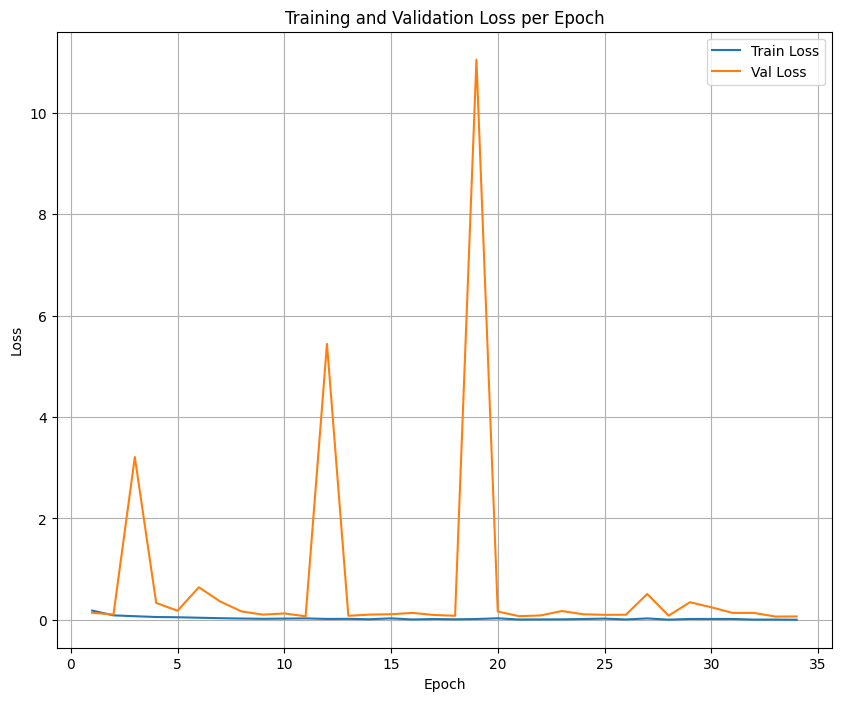

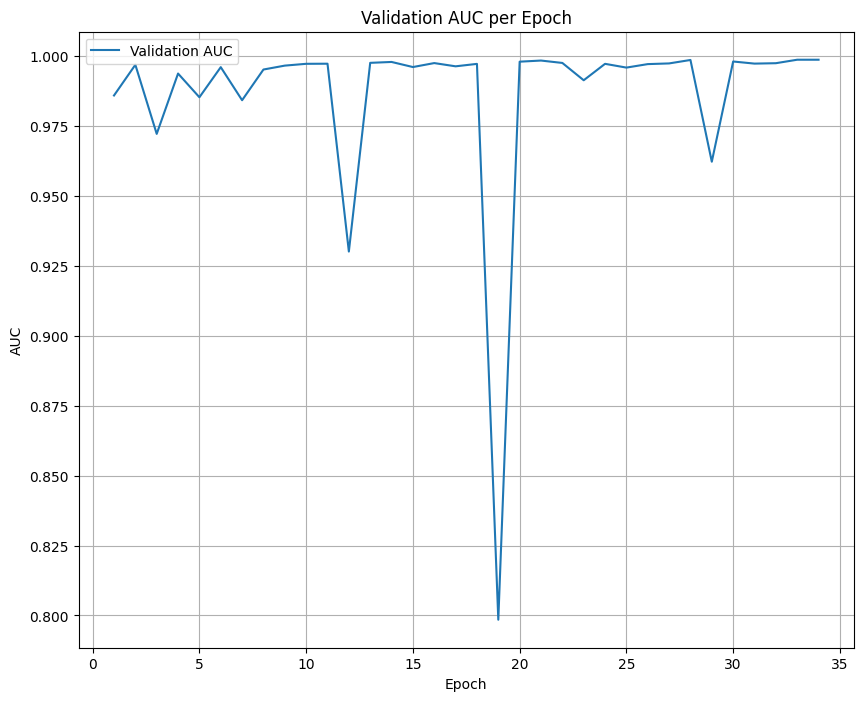

In [ ]:

plt.figure(figsize=(10, 8))
plt.plot(range(1, len(train_losses) + 1), train_losses, label="Train Loss")
plt.plot(range(1, len(val_losses) + 1), val_losses, label="Val Loss")
plt.title("Training and Validation Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()


plt.figure(figsize=(10, 8))
plt.plot(range(1, len(val_aucs) + 1), val_aucs, label="Validation AUC")
plt.title("Validation AUC per Epoch")
plt.xlabel("Epoch")
plt.ylabel("AUC")
plt.legend()
plt.grid()
plt.show()

In [ ]:

test_running_loss = 0.0
all_labels = []
all_probs = []


model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)
        test_running_loss += loss.item() * images.size(0)


        probs = torch.sigmoid(outputs).cpu().numpy()
        all_probs.extend(probs)
        all_labels.extend(labels.cpu().numpy())


test_loss = test_running_loss / len(test_loader.dataset)


all_probs_np = np.array(all_probs)
test_auc = roc_auc_score(all_labels, all_probs_np[:, 1])


predicted_labels = np.argmax(all_probs_np, axis=1)
precision, recall, f1_score, _ = precision_recall_fscore_support(all_labels, predicted_labels, average='binary')
cm = confusion_matrix(all_labels, predicted_labels)
print(f'Test Loss: {test_loss:.4f}')
print(f'Test AUC: {test_auc:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1_score:.4f}')
print(f'Confusion Matrix: {cm}')

Test Loss: 0.0954
Test AUC: 0.9972
Precision: 0.9398
Recall: 0.9811
F1 Score: 0.9600
Confusion Matrix: [[696  10]
 [  3 156]]


In the current experiment, although the F1 score increased slightly from 0.9598 to 0.96 and the validation loss dropped to 10+, indicating some improvement from parameter adjustments, the overall improvement is not significant. This suggests that ResNet152's potential in handling the class imbalance issue has nearly reached its limit. While fine-tuning can bring some optimizations, the room for further enhancement within this framework is limited.

Therefore, I plan to move on to a more powerful model, such as the Vision Transformer (ViT). Compared to ResNet, ViT's self-attention mechanism can capture global features more effectively, especially in complex tasks and imbalanced data scenarios. ViT not only handles different types of data more flexibly but also improves performance by learning global dependencies, offering the potential to overcome the limitations of ResNet152 and deliver more substantial improvements.
